In [1]:
from models import train_predict,CondensedGoogLeNet
from models.train_predict import get_confusion_matrix
from data.data_processing import generate_dummy_data,DataHandler,get_training_data_from_path
from config.hyperparams import GoogleNet_hyperparams
import tensorflow as tf
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
folder_for_samples = 'data/cnn_samples/regular'

# Data Processing

## Get stock data in Handler object

In [3]:
handler = DataHandler(encoding_method='GADF', window_len=64, image_size=16, retrain_freq=5,
                 start_date = 20150102, end_date= 20200102, frac_of_stocks=0.01,
                stock_data_dir_path= 'data/stock_data',
                 dir_for_samples=folder_for_samples, nb_of_stocks_by_file=50
                 )

In [4]:
handler.get_df_data()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


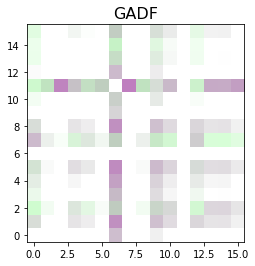

In [5]:
handler.show_image(handler.df_data)

## Builds images and targets and creates pickles
+ Be careful for the folder name (specified in handler object), this function will delete all files in this folder before dumping pickles

In [6]:
handler.build_and_dump_images_and_targets()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

# Training

## Retrieve data from the specified folder

In [7]:
%%time

X_train, X_val, X_test, Y_train, Y_val, Y_test = get_training_data_from_path(samples_path=folder_for_samples,
                                targets_type='VWAP_targets',
                                train_val_size=2 / 3.,
                                train_size=0.75,
                                logger_env='Training')


Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

Wall time: 70.8 ms


## Build the neural network object

In [8]:
shape_x,shape_y = list(X_train.shape),list(Y_train.shape)
shape_x[0],shape_y[0] = None,None

GoogleNet_hyperparams.update({'learning_rate':0.001})

network = CondensedGoogLeNet(shape_x=shape_x,shape_y=shape_y,hyperparams=GoogleNet_hyperparams)

## Train the network 

In [14]:
n_test = 2000
model_checkpoints_path = 'model_checkpoints/ckpt1'

X_train1, X_val1, Y_train1, Y_val1 =  X_train[:n_test], X_val[:n_test], Y_train[:n_test], Y_val[:n_test]


GN_pred, GN_training_loss, GN_val_loss = train_predict(X=X_train1, Y=Y_train1, batch_size=15, valX=X_val1, valY=Y_val1,
                                                       model_ckpt_path=model_checkpoints_path, is_bayesian=True,
                                                       epochs=3, net=network, dropout=0.15,save_step =2,cost_sensitive_loss=True)

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

In [28]:
GN_pred

array([[0.41095683, 0.37399882, 0.21504435],
       [0.37677366, 0.38684484, 0.23638147],
       [0.49119234, 0.27656853, 0.2322391 ],
       ...,
       [0.4270429 , 0.40375423, 0.16920291],
       [0.37940988, 0.3711643 , 0.24942586],
       [0.40036172, 0.37423813, 0.2254002 ]], dtype=float32)

In [29]:
GN_pred.shape

(5029, 3)

In [11]:
get_confusion_matrix(Y_val,GN_pred)

array([[1382, 1614,  555],
       [ 968, 1977,  664],
       [ 682, 1326,  890]], dtype=int64)

# Backtest

In [ ]:
# TODO

# Little tests section

In [30]:
import tensorflow as tf

In [15]:

# with tf.variable_scope('test',reuse=tf.AUTO_REUSE):
#     network2 = CondensedGoogLeNet(shape_x=shape_x,shape_y=shape_y,hyperparams=GoogleNet_hyperparams)
#     network2.build_operations(dropout=0.15)
sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('model_checkpoints/ckpt1-753.meta')
saver.restore(sess,tf.train.latest_checkpoint('model_checkpoints'))

INFO:tensorflow:Restoring parameters from model_checkpoints\ckpt1-399


In [16]:
graph = tf.get_default_graph()
# w1 = graph.get_tensor_by_name("w1:0")
# w2 = graph.get_tensor_by_name("w2:0")
# feed_dict ={w1:13.0,w2:17.0}



In [17]:
# network2.build_operations(dropout=0.15)

In [58]:
graph.get_operations()[1000:]

[<tf.Operation 'CondensedGoogLeNet/CondensedGoogLeNet/inception3/pooling1_conv/convolution/biases/Adam/Assign' type=Assign>,
 <tf.Operation 'CondensedGoogLeNet/CondensedGoogLeNet/inception3/pooling1_conv/convolution/biases/Adam/read' type=Identity>,
 <tf.Operation 'CondensedGoogLeNet/CondensedGoogLeNet/inception3/pooling1_conv/convolution/biases/Adam_1/Initializer/zeros' type=Const>,
 <tf.Operation 'CondensedGoogLeNet/CondensedGoogLeNet/inception3/pooling1_conv/convolution/biases/Adam_1' type=VariableV2>,
 <tf.Operation 'CondensedGoogLeNet/CondensedGoogLeNet/inception3/pooling1_conv/convolution/biases/Adam_1/Assign' type=Assign>,
 <tf.Operation 'CondensedGoogLeNet/CondensedGoogLeNet/inception3/pooling1_conv/convolution/biases/Adam_1/read' type=Identity>,
 <tf.Operation 'CondensedGoogLeNet/CondensedGoogLeNet/dense_layer/weight/Adam/Initializer/zeros/shape_as_tensor' type=Const>,
 <tf.Operation 'CondensedGoogLeNet/CondensedGoogLeNet/dense_layer/weight/Adam/Initializer/zeros/Const' type=C

+ CondensedGoogLeNet/loss/Mean gets the loss
+ CondensedGoogLeNet/Adam gets the optimizer
+ CondensedGoogLeNet/accuracy/Mean gets the accuracy
    + we can get the validation error just after
+ CondensedGoogLeNet/Merge/MergeSummary gets the summary op
+ CondensedGoogLeNet/init gets init_op
+ 

In [29]:
output = graph.get_tensor_by_name('CondensedGoogLeNet/output:0')
train_op = graph.get_tensor_by_name('CondensedGoogLeNet/Adam:0')
x = graph.get_tensor_by_name('CondensedGoogLeNet/x:0')
y = graph.get_tensor_by_name('CondensedGoogLeNet/y:0')
# loss = graph.get_tensor_by_name('CondensedGoogLeNet/loss/Mean:0')

In [46]:
pred = sess.run(train_op,feed_dict={x:X_val1[:100],y:Y_val1[:100]})

In [53]:
network.init

<tf.Operation 'CondensedGoogLeNet/init' type=NoOp>

In [49]:
train_op

<tf.Tensor 'CondensedGoogLeNet/Adam:0' shape=() dtype=int32_ref>

In [47]:
pred

408

In [48]:
pred = sess.run(output,feed_dict={x:X_val1[:15]})
pred

array([[0.54534346, 0.31630963, 0.13834698],
       [0.24215752, 0.27100408, 0.48683837],
       [0.19895326, 0.2448365 , 0.5562103 ],
       [0.46735036, 0.3460878 , 0.18656184],
       [0.28557023, 0.5997592 , 0.11467056],
       [0.3116192 , 0.43605033, 0.25233048],
       [0.21186991, 0.61546487, 0.17266521],
       [0.23539183, 0.67194796, 0.09266017],
       [0.12098232, 0.7968117 , 0.08220595],
       [0.13915536, 0.7540392 , 0.10680544],
       [0.26458594, 0.61498356, 0.1204305 ],
       [0.2907207 , 0.5771785 , 0.13210084],
       [0.18505928, 0.5521796 , 0.26276112],
       [0.20635134, 0.5497223 , 0.2439263 ],
       [0.28695482, 0.5000306 , 0.2130146 ]], dtype=float32)

In [58]:
X_val.shape

(1885, 16, 16, 4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EB8140E128>]],
      dtype=object)

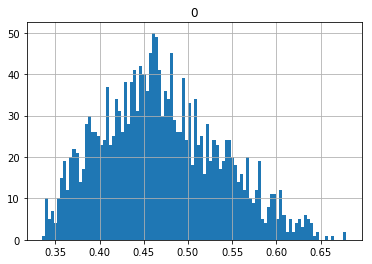

In [61]:
pd.DataFrame(np.max(pred,axis=1)).hist(bins=100)

In [46]:
pred[:5]

array([[0.37601736, 0.38016203, 0.24382067],
       [0.33472654, 0.37284032, 0.2924331 ],
       [0.35309193, 0.30750227, 0.33940583],
       [0.3471133 , 0.32821226, 0.3246745 ],
       [0.3240848 , 0.3507759 , 0.3251393 ]], dtype=float32)

In [42]:
GN_pred[:5]

array([[0.38847148, 0.36652684, 0.24500167],
       [0.32993904, 0.42600474, 0.24405627],
       [0.32316726, 0.3760524 , 0.30078036],
       [0.33141774, 0.36307806, 0.3055042 ],
       [0.36576766, 0.33067912, 0.30355325]], dtype=float32)

In [43]:
Y_val[:5]

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [16]:
pred.shape

(1885, 3)

In [ ]:
tf.reset_default_graph()

# Create some variables.
v1 = tf.get_variable("v1", shape=[3])
v2 = tf.get_variable("v2", shape=[5])

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "/tmp/model.ckpt")
  print("Model restored.")
  # Check the values of the variables
  print("v1 : %s" % v1.eval())
  print("v2 : %s" % v2.eval())

In [ ]:
tf.train.latest_checkpoint

In [3]:
tf.train.import_meta_graph

5